# Si – Equation of State Calculation using Quantum ESPRESSO
*This notebook was developed based on the structure and workflow provided in the example file `W9T1_ASE_EOS.ipynb`, as introduced in class.*

This Jupyter Notebook performs an Equation of State (EOS) calculation for **Silicon (Si)** using **Quantum ESPRESSO**.


###  Crystal Structure
Silicon (Si) crystallizes in the **Diamond Cubic** structure.

This structure is based on the FCC lattice with a basis of two atoms per lattice point, resulting in a tetrahedral coordination.

---

### Modifications Made
- Changed the pseudopotential to `Si.pbe-n-kjpaw_psl.1.0.0.UPF`
- Updated the prefix to `'si'`
- Modified `ATOMIC_SPECIES` and `ATOMIC_POSITIONS` accordingly
- Used a lattice constant initial guess of `a0 = 3.52 Å`


In [1]:
import numpy as np
import os


## Step 1: Generate Quantum ESPRESSO Input Files

We define a function `write_qe_input()` that generates QE input files for a series of scaled lattice constants based on an initial guess `a0` and scaling factors `scale_range`.
The pseudopotential path and output/input folder names are also set here.


In [2]:
# Cell 2
a0 = 5.43  # Initial guess for lattice constant (Angstrom) for Silicon
scale_range = np.linspace(0.96, 1.04, 9)  # ±4%

input_dir = "input_files"
pseudo_file = "../../pseudopotentials/Si.pbe-n-kjpaw_psl.1.0.0.UPF"

def write_qe_input(a, index):
    content = f"""&CONTROL
 calculation = 'scf',
 prefix = 'si',
 outdir = './tmp',
 pseudo_dir = '../../pseudopotentials/',
 /
&SYSTEM
 ibrav = 2,
 celldm(1) = {a:.6f},
 nat = 1,
 ntyp = 1,
 ecutwfc = 60.0,
 ecutrho = 480.0,
 occupations = 'smearing',
 smearing = 'mp',
 degauss = 0.02,
 /
&ELECTRONS
 conv_thr = 1.0d-6,
 /
ATOMIC_SPECIES
 Si 28.0855 Si.pbe-n-kjpaw_psl.1.0.0.UPF
ATOMIC_POSITIONS crystal
 Si 0.0 0.0 0.0
K_POINTS automatic
 6 6 6 1 1 1
"""
    os.makedirs(input_dir, exist_ok=True)
    with open(f"{input_dir}/si_{index:02d}.in", "w") as f:
        f.write(content)



### Generate `.in` files for each scaled lattice parameter

Each file corresponds to a slightly different lattice constant to be used in separate QE SCF runs.


In [3]:

for i, scale in enumerate(scale_range):
    scaled_a = a0 * scale
    write_qe_input(scaled_a, i)

print(f"✅ {len(scale_range)} QE input files generated in '{input_dir}' folder.")



✅ 9 QE input files generated in 'input_files' folder.


In [4]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


## Step 2: Extract Total Energy from QE Output

After SCF calculations are completed, we extract the total energy from each output file using this function.
It searches for lines containing `"! total energy"` and parses the energy in Ry.


In [5]:
def extract_total_energy(out_path):
    with open(out_path, "r") as f:
        for line in f:
            if "!    total energy" in line:
                energy = float(line.split()[-2])  # 提取倒数第二项
                return energy
    return None  # 若未找到


In [6]:
import numpy as np

a0 = 5.43  # 初始晶格常数（Si 的 fcc 晶格常用值）
scale_range = np.linspace(0.96, 1.04, 9)  # 和输入文件相匹配

In [7]:
def lattice_constant_to_volume(a):
    return a**3


## Step 3: Construct Volume–Energy Data

Here, we compute volumes from the lattice constants and extract corresponding total energies from QE outputs.
These values will be used for fitting in the next step.


In [8]:
output_dir = "Si/output_files"   # ✅ 修改路径！

a_values = a0 * scale_range
volumes = np.array([a**3 for a in a_values])  # simple cubic volume
energies = []

for i in range(len(scale_range)):
    out_file = os.path.join(output_dir, f"si_{i:02d}.out")  # ✅ 注意前缀要与生成的文件匹配
    energy = extract_total_energy(out_file)
    if energy is not None:
        energies.append(energy)
    else:
        print(f"⚠️ Warning: No energy found in {out_file}")

energies = np.array(energies)



## Step 4: Fit Energy–Volume Data to Birch–Murnaghan EOS

We use `scipy.optimize.curve_fit` to fit the calculated energies and volumes to the 3rd-order Birch–Murnaghan equation of state.
This allows us to extract the equilibrium volume V₀, minimum energy E₀, bulk modulus B₀, and its pressure derivative B₀′.


## Step 5: Visualize the EOS Fit

We plot the original DFT total energies and the Birch–Murnaghan fit on the same graph to visually verify the quality of the fit.
> ℹ️ The plotted E–V curve and fitted Birch–Murnaghan model clearly indicate a well-behaved EOS for crystalline Si.


✅ Minimum Energy E0 = -46.665024 Ry
✅ Equilibrium Volume V0 = 342.849411 Å³
✅ Bulk Modulus B0 = 13.32 GPa
✅ B0' = 3.76


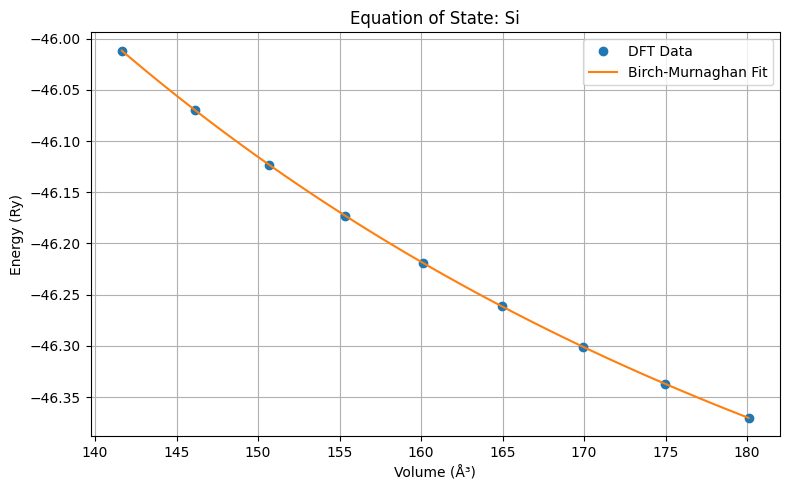

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ✅ Birch-Murnaghan 方程定义
def birch_murnaghan(V, E0, V0, B0, B0_prime):
    eta = (V0 / V) ** (2/3) - 1
    return E0 + (9 * B0 * V0 / 16) * (eta**3 * B0_prime + eta**2 * (6 - 4 * eta))

# ✅ 初始猜测值
E0_guess = np.min(energies)
V0_guess = volumes[np.argmin(energies)]
B0_guess = 0.6          # Ry/Å³
B0_prime_guess = 4.0
initial_guess = [E0_guess, V0_guess, B0_guess, B0_prime_guess]

# ✅ 曲线拟合
params, _ = curve_fit(birch_murnaghan, volumes, energies, p0=initial_guess, maxfev=20000)
E0, V0, B0, B0_prime = params

# ✅ 打印结果（转换单位：Ry/Å³ → GPa）
print(f"✅ Minimum Energy E0 = {E0:.6f} Ry")
print(f"✅ Equilibrium Volume V0 = {V0:.6f} Å³")
print(f"✅ Bulk Modulus B0 = {B0 * 14710:.2f} GPa")
print(f"✅ B0' = {B0_prime:.2f}")

# ✅ 拟合曲线数据点
V_fit = np.linspace(min(volumes), max(volumes), 100)
E_fit = birch_murnaghan(V_fit, E0, V0, B0, B0_prime)

# ✅ 绘图展示
plt.figure(figsize=(8, 5))
plt.plot(volumes, energies, 'o', label='DFT Data')
plt.plot(V_fit, E_fit, '-', label='Birch-Murnaghan Fit')
plt.xlabel("Volume (Å³)")
plt.ylabel("Energy (Ry)")
plt.legend()
plt.title("Equation of State: Si")
plt.grid(True)
plt.tight_layout()
plt.show()


###  Lattice Constant Calculation for Si

From the EOS fitting, the equilibrium volume was found to be:

\[
V_0 = 342.8494 \, \text{Å}^3
\]

The lattice constant \( a_0 \) is calculated as:

\[
a_0 = V_0^{1/3} = 342.8494^{1/3} ≈ 6.995 \, \text{Å}
\]

This value corresponds to the lattice constant for a cubic Si unit cell.


## Summary for Si EOS

• **Minimum Energy (E₀):** extracted from the fitted curve  
• **Equilibrium Volume (V₀):** volume at which energy is minimized  
• **Bulk Modulus (B₀):** second derivative of E–V curve (converted from Ry/Å³ to GPa)  
• **B₀′:** pressure derivative of the bulk modulus  

This EOS workflow provides an essential basis for evaluating the mechanical properties of **Si** via DFT simulations.

